In [1]:
using Revise
using ContGridMod
using Ferrite
using FerriteViz
# using GLMakie
using CairoMakie
using SparseArrays
using LinearAlgebra
using Flux
using Random
using Plots
using Makie
using BlockArrays
using DifferentialEquations
using SciMLSensitivity
Makie.inline!(true);

In [4]:
# Number of training and test set
NTRAIN = 48;
NTEST = 12;

In [5]:
# Load the grid
grid, scale_factor = get_grid("../data/borders/euro_border.json", 0.1, "panta.msh");
# Load the discrete model
dm = load_discrete_model("../data/ml/test_1.h5", scale_factor);
# Load the model, the distribution parameters are only important for the distribution of the power
model = get_params(grid, .05, dm, κ=0.02, bfactor=50000., σ=0.01, bmin=1);


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 10%] Meshing curve 7 (Line)
Info    : [ 10%] Meshing curve 8 (Line)
Info    : [ 10%] Meshing curve 9 (Line)
Info    : [ 10%] Meshing curve 10 (Line)
Info    : [ 10%] Meshing curve 11 (Line)
Info    : [ 10%] Meshing curve 12 (Line)
Info    : [ 10%] Meshing curve 13 (Line)
Info    : [ 10%] Meshing curve 14 (Line)
Info    : [ 10%] Meshing curve 15 (Line)
Info    : [ 20%] Meshing curve 16 (Line)
Info    : [ 20%] Meshing curve 17 (Line)
Info    : [ 20%] Meshing curve 18 (Line)
Info    : [ 20%] Meshing curve 19 (Line)
Info    : [ 20%] Meshing curve 20 (Line)
Info    : [ 20%] Meshing curve 21 (Line)
Info    : [ 20%] Meshing curve 22 (Line)
Info    : [ 20%] Meshing curve 23 (Line)
Info    : [ 20%] Meshing curve 24 (Line)
I

In [6]:
# load all discrete models
trainingDiscMod = ContGridMod.DiscModel[];
testDiscMod = ContGridMod.DiscModel[];
for i=1:NTRAIN
    push!(trainingDiscMod, load_discrete_model(
        "../data/ml/training_" * string(i) * ".h5", scale_factor));
end
for i=1:NTEST
    push!(testDiscMod, load_discrete_model(
        "../data/ml/test_" * string(i) * ".h5", scale_factor));
end

In [7]:
# Make sure that all slack busses are the same
# If nothing prints, everything is cool
slack = trainingDiscMod[1].id_gen[trainingDiscMod[1].id_slack]
for i=1:NTRAIN
    if trainingDiscMod[i].id_gen[trainingDiscMod[i].id_slack] != slack
        println(i)
    end
end
for i=1:NTEST
    if testDiscMod[i].id_gen[testDiscMod[i].id_slack] != slack
        println(i)
    end
end

In [8]:
# Set up training and test sets
# model.f₀ is the vector obtained from ∫p(x)u(x)dΩ
# TODO: Add the moment we still need to call stable_sol! for that, but we can also just assemble everything by hand
trainingTheta = zeros(size(trainingDiscMod[1].th, 1), NTRAIN);
testTheta = zeros(size(testDiscMod[1].th, 1), NTEST);
trainingP = zeros(getnnodes(grid), NTRAIN);
testP = zeros(getnnodes(grid), NTEST);
for i=1:NTRAIN
    update_model!(model, :p, trainingDiscMod[i], .05, κ=0.02, bfactor=50000., σ=0.01, bmin=1)
    stable_sol!(model)
    trainingP[:, i] = model.f₀;
    trainingTheta[:, i] = trainingDiscMod[i].th;
end
for i=1:NTEST
    update_model!(model, :p, testDiscMod[i], .05, κ=0.02, bfactor=50000., σ=0.01, bmin=1)
    stable_sol!(model)
    testP[:, i] = model.f₀;
    testTheta[:, i] = testDiscMod[i].th;
end
# Final update to recover the intial power distribution for later comparisons
update_model!(model, :p, dm, .05, κ=0.02, bfactor=50000., σ=0.01, bmin=1)

In [9]:
# Create matrices to obtain the stiffness matrix using just matrix multiplication and updating the susceptances in the quadrature points.
# The size of A is ndofs x 2 * number of total quadpoints, the factor two comes from the x and y components of the gradients
A = zeros(ndofs(model.dh₁), 2 * getnquadpoints(model.cellvalues) * size(model.grid.cells,1))
# The coordinates of the quadpoints to later create the projection matrix. This is an extremely lazy way of creating the projection matrix and should be easy to improve
q_coords = zeros(2 * getnquadpoints(model.cellvalues) * size(model.grid.cells,1), 2)

n_basefuncs = getnbasefunctions(model.cellvalues)
for (i, cell) in enumerate(CellIterator(model.dh₁))
    # upadate the cellvalues struct to contain the current cell
    Ferrite.reinit!(model.cellvalues, cell)    
    # this tells us the global index of the nodes of the current cell
    dofs = celldofs(cell)
    for q_point in 1:getnquadpoints(model.cellvalues)
        # The global coordinate of the current quad point
        x = spatial_coordinate(model.cellvalues, q_point, getcoordinates(cell))
        # ωᵢ det(J(x))
        dΩ = getdetJdV(model.cellvalues, q_point)
        # The index of this quadpoint in our labeling. The length 2 comes again from the x and y components of the gradients and susceptances
        ix = 2 * (i - 1) * getnquadpoints(model.cellvalues) + 2 * q_point - 1
        q_coords[ix, :] = q_coords[ix+1, :] = x
        for j in 1:n_basefuncs
            # Finally, do the assembly
            ∇φⱼ = shape_gradient(model.cellvalues, q_point, j)
            A[dofs[j], ix:ix+1] = ∇φⱼ * sqrt(dΩ)
    end
end
end
# Set the row corresponding to the slack node to zero. We can obtain the correct node directly from the ConstraintHandler
A[model.ch.prescribed_dofs, :] .= 0
A = sparse(A)
# Dim is the matrix containing only the one on the diagonal for the slack bus to make sure that the linear equations will have a unique solution
dim = zeros(ndofs(model.dh₁), ndofs(model.dh₁))
dim[model.ch.prescribed_dofs, model.ch.prescribed_dofs] .= 1
dim = sparse(dim);

In [10]:
# The values to compare to the ground truth are obtained by interpolating between nodal values.
# This can be broken down to matrix multiplication of a projection matrix and the nodal values.
# The way it works is simple: We need find the cell in which the point we would like is located.
# Then we obtain the local coordiantes x of that point. The interpolated value is then θ₁ * u₁(x) + θ₂ * u₂(x) + θ₃ * u₃(x).
# We just assemble a matrix that contains on row i the values of the shape functions needed to interpolate
# the point xᵢ at the column that corresponds to their global index.
# We basically do the same thing for the quadrature points. 
func_interpolations = Ferrite.get_func_interpolations(model.dh₁, :u)
proj = zeros(size(dm.th, 1), ndofs(model.dh₁))
q_proj = zeros(size(q_coords, 1), 2 * ndofs(model.dh₁))
# The coordinates of the nodes in our grid. We need that if one of the points we want to interpolate is 
# outside of our grid so we can find the closest node in the grid
grid_coords = [node.x for node in grid.nodes] 

for i = 1:size(dm.th, 1)
    # The PointEvalHandler finds the cell in which the point is located
    ph = PointEvalHandler(model.grid, [Ferrite.Vec(dm.coord[i, :]...)], warn=:false)
    # If no cell is found (the point is outside the grid), use the closest grid point instead
    if ph.cells[1] === nothing
        min_ix = argmin([norm(coord .- Ferrite.Vec(dm.coord[i, :]...)) for coord in grid_coords]) 
        ph = PointEvalHandler(grid, [grid_coords[min_ix]])
    end
    # Get the local coordinates
    pv = Ferrite.PointScalarValuesInternal(ph.local_coords[1], func_interpolations[1])
    # The cell degrees of freedom so we know which nodal value to use
    cell_dofs = Vector{Int}(undef, ndofs_per_cell(model.dh₁, ph.cells[1]))
    Ferrite.celldofs!(cell_dofs, model.dh₁, ph.cells[1])
    n_base_funcs = getnbasefunctions(pv)
    for j = 1:n_base_funcs
        # Finally this uᵢ(x)
        proj[i, cell_dofs[j]] = shape_value(pv, 1, j)
    end
end
# Basically the same thing for the quad points but we don't need to check whether a cell has been found
for (i, point) in enumerate(eachrow(q_coords))
    ph = PointEvalHandler(model.grid, [Ferrite.Vec(point...)])
    pv = Ferrite.PointScalarValuesInternal(ph.local_coords[1], func_interpolations[1])
    cell_dofs = Vector{Int}(undef, ndofs_per_cell(model.dh₁, ph.cells[1]))
    Ferrite.celldofs!(cell_dofs, model.dh₁, ph.cells[1])
    n_base_funcs = getnbasefunctions(pv)
    for j = 1:n_base_funcs
        # Some trickery because we sort our b nodal values as (bx(x1), by(x1), bx(x2), by(x2), etc.)
        if mod(i, 2) == 0
            q_proj[i, 2 * cell_dofs[j]] = shape_value(pv, 1, j)
        else
            q_proj[i, 2 * cell_dofs[j] - 1] = shape_value(pv, 1, j)
        end
    end
end
q_proj = sparse(q_proj);
proj = sparse(proj);

In [25]:
# Set up the machine learning
N = getnnodes(model.grid)
opt = ADAM(0.1)
# (bx, by, bx, by, etc.)
# b = 100 * rand(2 * ndofs(model.dh₁)) .+ 0.1
param = Flux.params(b);
nEpochs = 1000;
nBatches = 3;
batchSize = Int64(NTRAIN / nBatches);
shuffledIx = randperm(NTRAIN);

In [26]:
# Actual learning
err = zeros(nEpochs * nBatches)
for e=1:nEpochs
    for batch=1:nBatches
        local _err
        gs = Flux.gradient(param) do
            # Ensure that b is positive
            btemp = max.(b, 0.1)
            K = sparse(A * diagm(q_proj * btemp) * A' + dim)
            θ = proj * (K \ trainingP[:, shuffledIx[(batch - 1) * batchSize + 1:batch * batchSize]])
            # _err = mean(abs2, θ .- trainingTheta[:, shuffledIx[(batch - 1) * batchSize + 1:batch * batchSize]])
            _err = Flux.Losses.huber_loss(θ, trainingTheta[:, shuffledIx[(batch - 1) * batchSize + 1:batch * batchSize]], δ=0.1)
            return _err
        end
        if(mod(e,50) == 0 && batch == 1)
            println([e _err])
        end
        err[(e - 1) * nBatches + batch] = _err
        Flux.update!(opt, param, gs)
    end
end
b = max.(b, 0.1);

[50.0 0.011301352472922483]
[100.0 0.010974083658288189]
[150.0 0.010725931583414528]
[200.0 0.01052168556382855]
[250.0 0.010341561658014092]
[300.0 0.010182247257076994]
[350.0 0.010039545901231468]
[400.0 0.009913525611035886]
[450.0 0.009797692010151775]
[500.0 0.009689545909503418]
[550.0 0.00959268098972191]
[600.0 0.009509693194843589]
[650.0 0.009431796641800458]
[700.0 0.009362030460153879]
[750.0 0.009300007174101897]
[800.0 0.009238382935343894]
[850.0 0.009179435317945222]
[900.0 0.009129692083810731]
[950.0 0.009083462717119562]
[1000.0 0.009040623631801659]


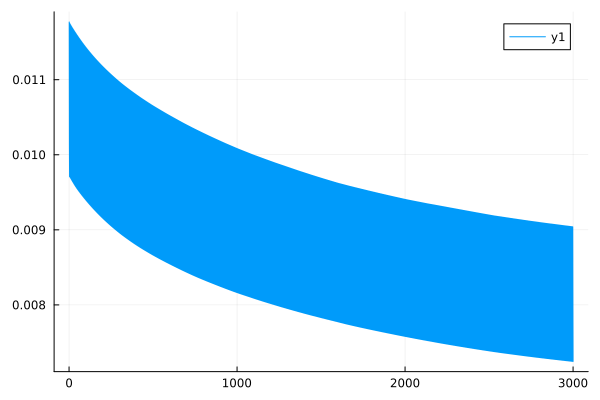

In [27]:
Plots.plot(err)

In [28]:
# Update the model with the learned susceptances
update_model!(model, :bx, b[1:2:end])
update_model!(model, :by, b[2:2:end])

In [ ]:
# Save / Load the learned values
using DelimitedFiles
# writedlm("bxlearned.csv", b[1:2:end], ',')
# writedlm("bylearned.csv", b[2:2:end], ',')
# bx = readdlm("../test/bxlearned.csv", ',');
# by = readdlm("../test/bylearned.csv", ',');
update_model!(model, :bx, vec(bx))
update_model!(model, :by, vec(by))
stable_sol!(model)

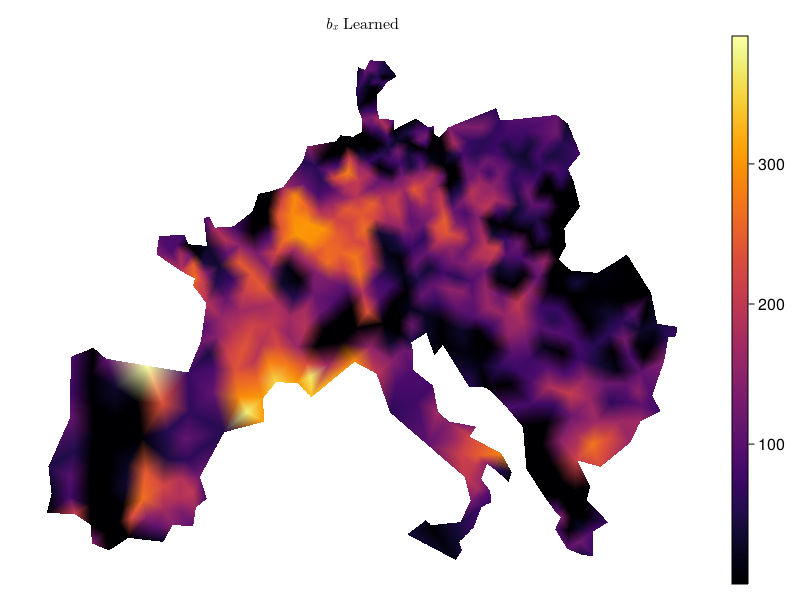

In [29]:
# Plot of the learned xx component of the susceptance tensor
# Using the more bare bones solutionplot instead of the plotting utils I wrote for some 
# Make "magic"
f = Figure()
ax = Axis(f[1, 1], title=L"$b_x$ Learned")
sp = solutionplot!(model.dh₁, getproperty(model, :bx_nodal), colormap=:inferno)
Colorbar(f[1, 2], sp)
hidedecorations!(ax)
hidespines!(ax)
Makie.save("bx.pdf", f)
f


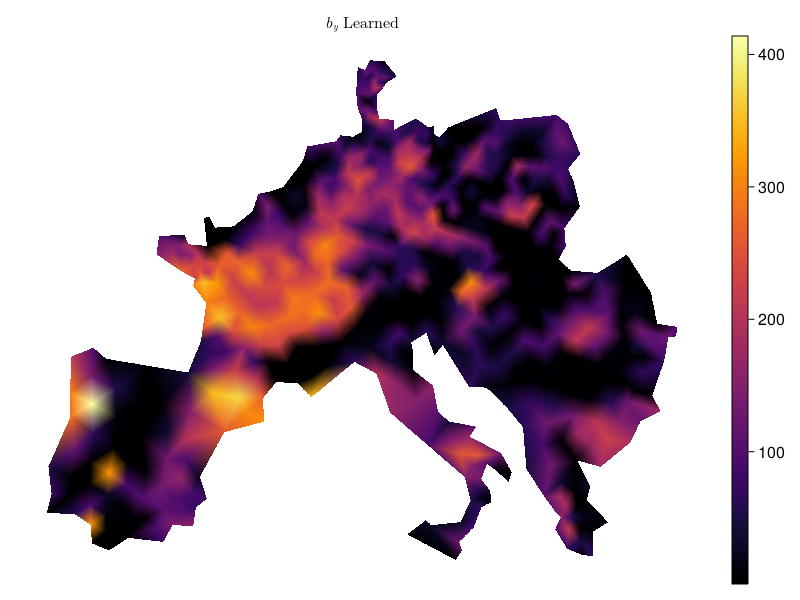

In [30]:
# Plot of the learned yy component of the susceptance tensor
f = Figure()
ax = Axis(f[1, 1], title=L"$b_y$ Learned")
sp = solutionplot!(model.dh₁, getproperty(model, :by_nodal), colormap=:inferno)
Colorbar(f[1, 2], sp)
hidedecorations!(ax)
hidespines!(ax)
save("./by.pdf", f)
f

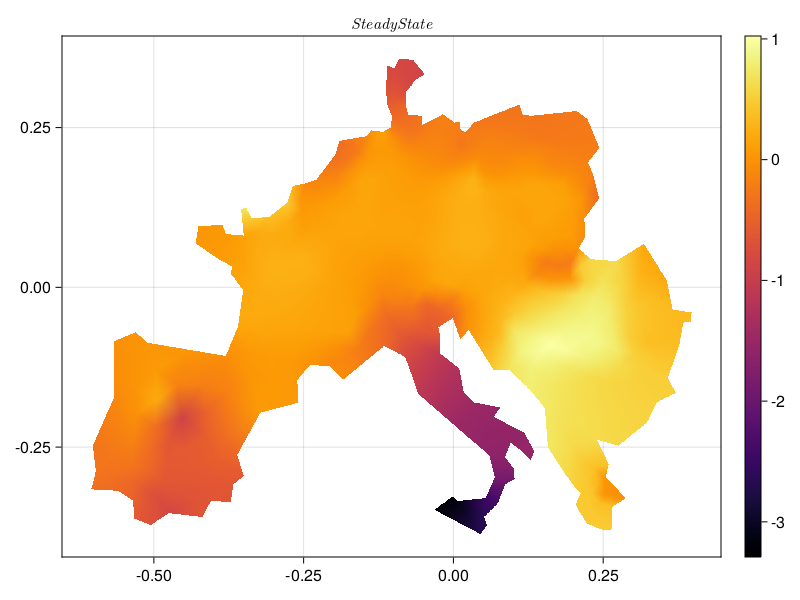

In [31]:
# Plot of the stable solution with the learned parameters
stable_sol!(model)
f = Figure()
ax = Axis(f[1, 1], title=L"Steady State")
sp = solutionplot!(model.dh₁, getproperty(model, :θ₀_nodal), colormap=:inferno)
Colorbar(f[1, 2], sp)
# hidedecorations!(ax)
# hidespines!(ax)
# save("./theta0.pdf", f)
f

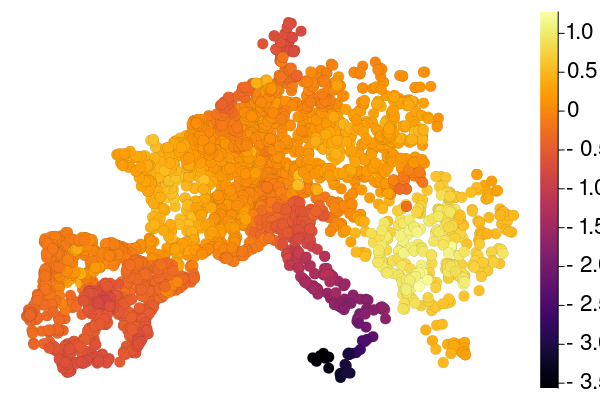

In [32]:
# For comparison the stable solution of the discrete model
ContGridMod.disc_plot(dm.coord[:,[2,1]], dm.th)
# Plots.savefig("theta0disc.pdf")

In [33]:
# Highly inefficent way to calculate the predictions from our newly trained model.
# It would be way faster to use the stiffness matrix as in the training for that.
# This was just done to make sure that the stiffness matrix I calculated is actually
# the same as the Ferrite one. This code can be replaced.
coords = [Ferrite.Vec(dm.coord[i, :]...) for i=1:size(dm.coord, 1)]
trainingThetaPred = zeros(size(trainingDiscMod[1].th, 1), NTRAIN);
testThetaPred = zeros(size(testDiscMod[1].th, 1), NTEST);
for i=1:NTRAIN
    update_model!(model, :p, trainingDiscMod[i], .05, κ=0.02, bfactor=50000., σ=0.01, bmin=1)
    stable_sol!(model)
    trainingThetaPred[:, i] = model.θ₀(coords);
end
for i=1:NTEST
    update_model!(model, :p, testDiscMod[i], .05, κ=0.02, bfactor=50000., σ=0.01, bmin=1)
    stable_sol!(model)
    testThetaPred[:, i] = model.θ₀(coords);
end

There are points which are outside the grid. There value will be set to the value of the closest grid point.


In [ ]:
# Create a huge plot with all the comparison for the training data.
# Acutal plots should be done in Python as its a million times easier ;)
trainingPlots = Plots.Plot[]

for i=1:NTRAIN
    min, max = extrema([trainingTheta[:,i] trainingThetaPred[:,i]])
    delta = max - min
    pad = 0.05 * delta
    min -= pad
    max += pad
push!(trainingPlots, Plots.scatter(trainingTheta[:,i], trainingThetaPred[:,i], xlims=(min, max), ylims=(min, max), label="Training Set " * string(i)))
end

Plots.plot(trainingPlots..., layout=(12,4), size=(1500, 3000))

In [ ]:
# Plots for the test cases
testPlots = Plots.Plot[]

for i=1:NTEST
    min, max = extrema([testTheta[:,i] testThetaPred[:,i]])
    delta = max - min
    pad = 0.05 * delta
    min -= pad
    max += pad
push!(testPlots, Plots.scatter(testTheta[:,i], testThetaPred[:,i], xlims=(min, max), ylims=(min, max), label="Test Set " * string(i)))
end

Plots.plot(testPlots..., layout=(4,3), size=(1125, 1000))

In [35]:
using DelimitedFiles
# Save all the predicted and actual data for plotting in a proper language
writedlm("../test/trainingtheta.csv", trainingTheta, ',')
writedlm("../test/trainingthetapred.csv", trainingThetaPred, ',')
writedlm("../test/testtheta.csv", testTheta, ',')
writedlm("../test/testthetapred.csv", testThetaPred, ',')

In [9]:
# Now let's do some dynamical simulations.
# First we add a perturbation around a generator in Greece
add_local_disturbance!(model, dm.coord[3426,:], -9., 0.05)

In [10]:
# Calculate the expected frequency and run a numerical simulation
println("Synchronized freq: ", ContGridMod.integrate(model.dh₁, model.cellvalues, model.fault) / ContGridMod.integrate(model.dh₁, model.cellvalues, model.d))
sol = perform_dyn_sim(model, 50.);
# The saved solution can be openend with ParaView
save_simulation(model, sol, "fault")

Synchronized freq: -0.273753534510952


In [11]:
# Projection matrix for the omega values onto the discrete coordinates.
# Basically the same as before. A little more caution needs to be used however as the
# order how the degrees of freedom for the θ and ω fields are stored in the DofHandler
# is not straight forward
func_interpolations = Ferrite.get_func_interpolations(model.dh₂, :ω)
proj_ω = zeros(size(dm.th, 1), ndofs(model.dh₂))

for i = 1:size(dm.th, 1)
    ph = PointEvalHandler(model.grid, [Ferrite.Vec(dm.coord[i, :]...)], warn=:false)
    if ph.cells[1] === nothing
        min_ix = argmin([norm(coord .- Ferrite.Vec(dm.coord[i, :]...)) for coord in grid_coords]) 
        ph = PointEvalHandler(grid, [grid_coords[min_ix]])
    end
    pv = Ferrite.PointScalarValuesInternal(ph.local_coords[1], func_interpolations[1])
    cell_dofs = Vector{Int}(undef, ndofs_per_cell(model.dh₂, ph.cells[1]))
    Ferrite.celldofs!(cell_dofs, model.dh₂, ph.cells[1])
    n_base_funcs = getnbasefunctions(pv)
    dofr = dof_range(model.dh₂, :ω)
    for j = 1:n_base_funcs
        proj_ω[i, cell_dofs[dofr[j]]] = shape_value(pv, 1, j)
    end
end
proj_ω = sparse(proj_ω);

In [12]:
# Project the omega values
omegas_cont = zeros(size(sol.u, 1), 3809)
for i=1:size(omegas_cont, 1)
    omegas_cont[i, :] = proj_ω * sol.u[i]
end

In [ ]:
# Discrete dynamics
tdisc, vdisc = disc_dynamics(dm, 0., 25., -9.0, faultid=findfirst(dm.id_gen[dm.p_gen .>0] .== 3426), dt=.01);

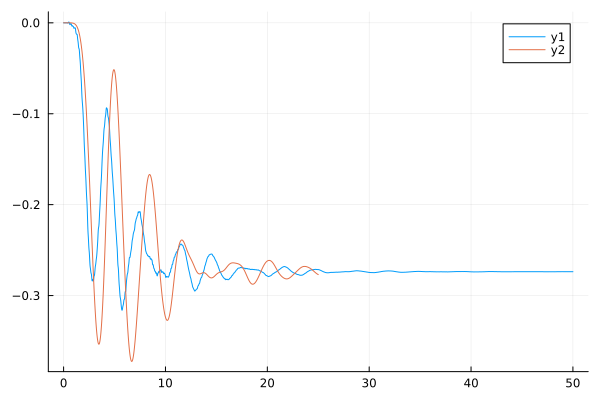

In [16]:
# Some comparison for a generator in spain
Plots.plot(sol.t, omegas_cont[:, 3000])
Plots.plot!(tdisc, vdisc[:, 3000])

In [8]:
# Now we would like to learn the dynamical parameters. For this we have to factorize
# the stiffness matrix. The only part of the stiffness matrix that will change is 
# the ω-ω part containing d(x). The rest is constant and we can just create it now

# This is all pretty standard of how to assemble stuff with Ferrite
K_dyn = create_sparsity_pattern(model.dh₂)
f_dyn = zeros(ndofs(model.dh₂))
n_basefuncs_θ = getnbasefunctions(model.cellvalues)
n_basefuncs_ω = getnbasefunctions(model.cellvalues)
n_basefuncs = n_basefuncs_θ + n_basefuncs_ω
θ▄, ω▄ = 1, 2

Kₑ = PseudoBlockArray(zeros(n_basefuncs, n_basefuncs), [n_basefuncs_θ, n_basefuncs_ω], [n_basefuncs_θ, n_basefuncs_ω])
fₑ = zeros(n_basefuncs)

assembler = start_assemble(K_dyn, f_dyn)

for cell in CellIterator(model.dh₂)
    fill!(Kₑ, 0)
    fₑ .= 0

    Ferrite.reinit!(model.cellvalues, cell)

    for q_point in 1:getnquadpoints(model.cellvalues)
        x = spatial_coordinate(model.cellvalues, q_point, getcoordinates(cell))
        b = SparseMatrixCSC(diagm([model.bx(x), model.by(x)]))
        dΩ = getdetJdV(model.cellvalues, q_point)
        for i in 1:n_basefuncs_θ
            φᵢ = shape_value(model.cellvalues, q_point, i)
            ∇φᵢ = shape_gradient(model.cellvalues, q_point, i)
            for j in 1:n_basefuncs_ω
                φⱼ = shape_value(model.cellvalues, q_point, j)
                ∇φⱼ = shape_gradient(model.cellvalues, q_point, j)
                Kₑ[BlockIndex((θ▄, ω▄), (i, j))] += φᵢ ⋅ φⱼ * dΩ
                Kₑ[BlockIndex((ω▄, θ▄), (i, j))] -= ∇φᵢ ⋅ (b * ∇φⱼ) * dΩ
                Kₑ[BlockIndex((θ▄, θ▄), (i, j))] = 0
                Kₑ[BlockIndex((ω▄, ω▄), (i, j))] = 0
            end
            fₑ[n_basefuncs_θ+i] += (model.p(x) + model.fault(x)) * φᵢ * dΩ
        end
    end

    assemble!(assembler, celldofs(cell), Kₑ, fₑ)
end
dropzeros!(K_dyn);

In [9]:
# This is the A matrix for the damping. Everything is the same as for the susceptanes except we only have one value per 
# quadrature point
A_d = zeros(ndofs(model.dh₂), getnquadpoints(model.cellvalues) * size(model.grid.cells,1))
q_coords_d = zeros(getnquadpoints(model.cellvalues) * size(model.grid.cells,1), 2)
n_basefuncs = getnbasefunctions(model.cellvalues)
dofr = dof_range(model.dh₂, :ω)
for (i, cell) in enumerate(CellIterator(model.dh₂))
    Ferrite.reinit!(model.cellvalues, cell)    
    dofs = celldofs(cell)
    for q_point in 1:getnquadpoints(model.cellvalues)
        x = spatial_coordinate(model.cellvalues, q_point, getcoordinates(cell))
        dΩ = getdetJdV(model.cellvalues, q_point)
        ix = (i - 1) * getnquadpoints(model.cellvalues) + q_point
        q_coords_d[ix, :] = x
        for j in 1:n_basefuncs
            φⱼ = shape_value(model.cellvalues, q_point, j)
            A_d[dofs[dofr[j]], ix] = φⱼ * sqrt(dΩ)
    end
end
end
A_d = sparse(A_d);

In [10]:
# Matrix to project the nodal values of d onto the quadrature points.
# Pretty much the same as before, we just have to find the degrees of freedom 
# that correspond to the ω field in our DofHandler first
q_proj_d = zeros(size(q_coords_d, 1), ndofs(model.dh₂)÷2)
func_interpolations_d = Ferrite.get_func_interpolations(model.dh₂, :ω)
omega_dofs = Set{Int64}()
dofr = dof_range(model.dh₂, :ω)
for i = 1:size(model.grid.cells, 1)
    cell_dofs = Vector{Int}(undef, ndofs_per_cell(model.dh₂, i))
    Ferrite.celldofs!(cell_dofs, model.dh₂, i)
    push!(omega_dofs, cell_dofs[dofr]...)
end
odofs_dict = Dict(j => i for (i, j) in enumerate(sort(collect(omega_dofs))))
for (i, point) in enumerate(eachrow(q_coords_d))
    ph = PointEvalHandler(model.grid, [Ferrite.Vec(point...)])
    pv = Ferrite.PointScalarValuesInternal(ph.local_coords[1], func_interpolations_d[1])
    cell_dofs = Vector{Int}(undef, ndofs_per_cell(model.dh₂, ph.cells[1]))
    Ferrite.celldofs!(cell_dofs, model.dh₂, ph.cells[1])
    n_base_funcs = getnbasefunctions(pv)
    for j = 1:n_base_funcs
        q_proj_d[i, odofs_dict[cell_dofs[dofr[j]]]] = shape_value(pv, 1, j)
    end
end
q_proj_d = sparse(q_proj_d);

In [11]:
# So far we keep the mass matrix constant but it should be straight forward to make 
# M also parameter dependent 
M = create_sparsity_pattern(model.dh₂)
ContGridMod.assemble_M!(M, model)
dropzeros!(M);

In [12]:
# Create intiial conditions
ch = ConstraintHandler(model.dh₂)
db = Dirichlet(:θ, Set(1 : getnnodes(model.grid)), (x, t) -> model.θ₀(x))
add!(ch, db)
close!(ch)
update!(ch, 0)
u₀ = zeros(ndofs(model.dh₂))
apply!(u₀, ch);

In [36]:
# Functions for our dynamical simulation. The damping is passed as parameter p
function dif!(du, u, p, t)
    K_d = K_dyn - A_d * p * spdiagm(q_proj_d * model.d_nodal) * A_d'
    mul!(du, K_d, u)
    du .+= f_dyn
end
function jac!(J, u, p, t)
    K_d = K_dyn - A_d * p * spdiagm(q_proj_d  * model.d_nodal) * A_d'
    J[:, :] .= K_d
end

jac! (generic function with 1 method)

In [44]:
# Set up the DiffEquation.jl problem
jac_sparsity = sparse(K)
rhs = ODEFunction(dif!, mass_matrix=M, jac_prototype=jac_sparsity,jac=jac!)
problem = ODEProblem(rhs, u₀, (0, 25), 1);

In [45]:
# Try to do some adjoint sensitivity method
sol = solve(problem, Trapezoid(), sensealg=QuadratureAdjoint(), progress = true, progress_steps = 1,);

ODE   0%|                                               |  ETA: N/A
ODE   0%|                                               |  ETA: 44925.55 days
ODE   0%|                                               |  ETA: 37438.44 days
ODE   0%|                                               |  ETA: 32090.36 days
ODE   0%|                                               |  ETA: 13213.84 days
ODE   0%|                                               |  ETA: 3828.11 days
ODE   0%|                                               |  ETA: 1886.53 days
ODE   0%|                                               |  ETA: 876.25 days
ODE   0%|                                               |  ETA: 533.62 days
ODE   0%|                                               |  ETA: 313.55 days
ODE   0%|                                               |  ETA: 219.07 days
ODE   0%|                                               |  ETA: 149.33 days
ODE   0%|                                               |  ETA: 113.11 days
ODE   0%| 